### Overview

GenAI career assistant designed to simply and support GenAI learning, resume preparation, interview assistant and job hunting.

## Tech Stack
Langchain, Langgraph, Gemini LLM, DuckDuckGoSearchResult

### Key Features
1. Learning and Content Creation
2. Q&A Support
3. Resume Building & Review
4. Interview Preparation
5. Job search Assistant

In [1]:
# Import 
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

from IPython.display import display, Image, Markdown
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
import os

load_dotenv()

os.environ["GOOGLE_API_KEY"] =  os.getenv('GOOGLE_API_KEY')

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                             verbose=True,
                             temperature=0.5,
                             api_key=os.getenv("GOOGLE_API_KEY"))


In [2]:
class State(TypedDict):
    query:str
    category:str
    response:str

In [3]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, trim_messages

def trim_conversation(prompt):
    "trims convo history to retain only latest messages"
    max_messages = 10
    return trim_messages(
        prompt,
        max_tokens=max_messages,
        strategy='last',
        token_counter=len,
        start_on="human",
        include_system=True,
        allow_partial=False,
    )

from datetime import datetime

def save_file(data, filename):
    """saves data to a markdown file"""
    folder_name = "Agent_output"
    os.makedirs(folder_name, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    filename = f"{filename}_{timestamp}.md"
    file_path = os.path.join(folder_name, filename)
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(data)
        print(f"File '{file_path}' created sucessfully.")

    return file_path

def show_md_file(file_path): 
    with open(file_path, "r", encoding="utf-8") as file:
        content = file.read()
    display(Markdown(content))
    

In [4]:
from langchain_core.prompts import ChatMessagePromptTemplate, MessagesPlaceholder
from langchain_community.tools import DuckDuckGoSearchResults
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor

class LearningResourceAgent:
    def __init__(self, prompt):
        self.model = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
        self.prompt = prompt
        self.tools = [DuckDuckGoSearchResults()]

    def TutorialAgent(self, user_input):
        agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        agent_executer = AgentExecutor(agent = agent, tools=self.tools, verbose=True)
        response = agent_executer.invoke({"input":user_input})

        # Save and display the response
        path = save_file(str(response.get('output')).replace("```markdown", "").strip(), 'Tutorial')
        print(f"Tutorial saved to {path}")
        return path
        
    def QueryBot(self, user_input):
        print("\nStarting the Q&A session. Type 'exit' to end the session.\n")
        record_QA_session = []
        record_QA_session.append('User Query: %s \n' %user_input)
        self.prompt.append(HumanMessage(content=user_input))
        while True:
            # Trim conversation to not break the context window 
            self.prompt = trim_conversation(self.prompt)

            # Generate a response from the AI model and update the conversation history
            response = self.model.invoke(self.prompt)
            record_QA_session.append('\n Expert Response: %s \n' % response.content)

            self.prompt.append(AIMessage(content = response.content))

            print('*' * 50 + 'AGENT' + '*' * 50)
            print("\n EXPERT AGENT RESPONSE:", response.content)

            print('*' * 50 + 'USER' + '*' * 50)
            user_input = input("\n Your Query: ")
            record_QA_session.append('\n User Query: %s\n' % response.content)
            self.prompt.append(HumanMessage(content=user_input))


            # exit 
            if user_input.lower() == 'exit':
                print("Ending the chat session.")
                path = save_file(''.join(record_QA_session), 'Q&A_Doubt_Session')
                print(f"Q&A Session saved to {path}")
                return path

## Class for interview handling
Interview Question preparation and mockInterview

In [5]:
class InterviewAgent:
    def __init__(self, prompt):
        self.model = ChatGoogleGenerativeAI(model='gemini-1.5-flash')
        self.prompt = prompt
        self.tools = [DuckDuckGoSearchResults()]

    def Interview_question(self, user_input):
        # convo history
        chat_history = []
        questions_bank = ''

        # Agent and agent executor
        self.agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        self.agent_executor = AgentExecutor(agent=self.agent, tools=self.tools, verbose=True, handle_parsing_errors=True)
        while True:
            print("\nStarting the Interview question preparation. Type 'exit' to end the session.\n")
            if user_input.lower() == "exit":
                print("Ending the conversation. GoodBye!")
                break

            response = self.agent_executor.invoke({"input":user_input, "chat_history":chat_history})
            questions_bank += str(response.get('output')).replace("```markdown", "").strip() + "\n"

            chat_history.extend([HumanMessage(content=user_input), response["output"]])
            if len(chat_history) > 10:
                chat_history = chat_history[-10:]

            user_input = input("you: ")


        path = save_file(questions_bank, 'Interview_questions')
        print(f"Interview question saved to {path}")
        return path
    
    def Mock_Interview(self):
        # Start a mock interview session
        print("\nStarting the mock Interview. Type 'exit' to end the session.\n")

        # Starting message and history records
        initial_message = 'I am ready for the interview.\n'
        interview_record = []
        interview_record.append('Candidate: %s \n' % initial_message)
        self.prompt.append(HumanMessage(content=initial_message))

        while True:
            # Trim convo
            self.prompt = trim_conversation(self.prompt)
            response = self.model.invoke(self.prompt)

            self.prompt.append(AIMessage(content=response.content))
            print("\nInterviewer:", response.content)
            interview_record.append('\nInterviewer: %s\n' % response.content)

            user_input = input("\nCandidate: ")
            interview_record.append('\nCandidate: %s \n' %user_input)

            self.prompt.append(HumanMessage(content=user_input))

            if user_input.lower() == 'exit':
                print("Ending the interview session.")
                path = save_file(''.join(interview_record), 'Mock_interview')
                print(f"Mock Interview saved to {path}")
                return path

## Resume Making which will handle creating resume by chating with user
for now need to copy and paste the resume content in text format.

In [6]:
class ResumeMaker:
    def __init__(self, prompt):
        # Initialize the chat model, prompt template, and search tool for resume creation
        self.model = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
        self.prompt = prompt
        self.tools = [DuckDuckGoSearchResults()]  # Search tool to gather additional information if needed
        # Create an agent executor with tool access, enabling verbose output and error handling
        self.agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        self.agent_executor = AgentExecutor(agent=self.agent, tools=self.tools, verbose=True, handle_parsing_errors=True)

    def Create_Resume(self, user_input):
        # Maintain chat history for the resume creation conversation
        chat_history = []
        while True:
            print("\nStarting the Resume create session. Type 'exit' to end the session.\n")
            if user_input.lower() == "exit":
                print("Ending the conversation. Goodbye!")
                break
            
            # Generate a response to user input using the agent and add it to the chat history
            response = self.agent_executor.invoke({"input": user_input, "chat_history": chat_history})
            chat_history.extend([HumanMessage(content=user_input), response["output"]])
            
            # Limit the chat history to the last 10 messages
            if len(chat_history) > 10:
                chat_history = chat_history[-10:]
            
            # Prompt for the next user input to continue the resume creation conversation
            user_input = input("You: ")
        
        # Save the final output as a markdown file and return the file path
        path = save_file(str(response.get('output')).replace("```markdown", "").strip(), 'Resume')
        print(f"Resume saved to {path}")
        return path


## Job Search
fetches job posts from the web

In [7]:
class JobSearch:
    def __init__(self, prompt):
        self.model = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
        self.prompt = prompt
        self.search_tool = DuckDuckGoSearchResults()
        
    def find_jobs(self, user_input):
        # Create a more specific search query        
        # Get search results
        search_results = self.search_tool.run(user_input)
        
        # Process results through LLM
        chain = self.prompt | self.model
        formatted_jobs = chain.invoke({
            "result": search_results
        })
        
        # Format and save results
        jobs_content = formatted_jobs.content
        path = save_file(str(jobs_content).replace("```markdown", "").strip(), 'Job_search')
        return path

In [8]:
# class JobSearch:
#     def __init__(self, prompt):
#         self.model = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
#         self.prompt = prompt
#         self.tools = DuckDuckGoSearchResults()

#     def find_jobs(self, user_input):
#         results = self.tools.invoke(user_input)
#         chain = self.prompt | self.model
#         jobs = chain.invoke({"result":results}).content

#         path = save_file(str(jobs).replace("```markdown", "").strip(), 'Job_search')
#         print(f"Jobs saved to {path}")
#         return path

## Creating Functions which will help to categorize our user input
1. Categorize
2. handle_learning_resource
3. handle_interview_preparation

In [9]:
def categorize(state: State) -> State:
    """Categorize the user query into one of four main categories: Learn Generative AI Technology, Resume Making, Interview Preparation, or Job Search."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories:\n"
        "1: Learn Generative AI Technology\n"
        "2: Resume Making\n"
        "3: Interview Preparation\n"
        "4: Job Search\n"
        "Give the number only as an output.\n\n"
        "Examples:\n"
        "1. Query: 'What are the basics of generative AI, and how can I start learning it?' -> 1\n"
        "2. Query: 'Can you help me improve my resume for a tech position?' -> 2\n"
        "3. Query: 'What are some common questions asked in AI interviews?' -> 3\n\n"
        "Now, categorize the following customer query:\n"
        "Query: {query}"
    )

    chain = prompt | llm
    print('Categorizing the customer query...')
    category = chain.invoke({"query":state["query"]}).content.strip()
    return {"category":category}

def handle_learning_resource(state:State) -> State:
    """Determine if the query is related to Tutorial creation or general Questions on GENAI topics."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following user query into one of these categories:\n\n"
        "Categories:\n"
        "- Tutorial: For queries related to creating tutorials, blogs, or documentation on generative AI.\n"
        "- Question: For general queries asking about generative AI topics.\n"
        "- Default to Question if the query doesn't fit either of these categories.\n\n"
        "Examples:\n"
        "1. User query: 'How to create a blog on prompt engineering for generative AI?' -> Category: Tutorial\n"
        "2. User query: 'Can you provide a step-by-step guide on fine-tuning a generative model?' -> Category: Tutorial\n"
        "3. User query: 'Provide me the documentation for Langchain?' -> Category: Tutorial\n"
        "4. User query: 'What are the main applications of generative AI?' -> Category: Question\n"
        "5. User query: 'Is there any generative AI course available?' -> Category: Question\n\n"
        "Now, categorize the following user query:\n"
        "The user query is: {query}\n"
    )

    chain = prompt | llm
    print("Categorizing the customer query further...")
    response = chain.invoke({"query":state["query"]}).content
    return {"category":response}

def handle_interview_preparation(state: State) -> State:
    """Determine if the query is related to Mock Interviews or general interview questions."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following user query into one of these categories:\n\n"
        "Categories:\n"
        "- Mock: For requests related to mock interviews.\n"
        "- Question: For general queries asking about interview topics or preparation.\n"
        "- Default to Question if the query doesn't fit either of these categories.\n\n"
        "Examples:\n"
        "1. User query: 'Can you conduct a mock interview with me for a Gen AI role?' -> Category: Mock\n"
        "2. User query: 'What topics should I prepare for an AI Engineer interview?' -> Category: Question\n"
        "3. User query: 'I need to practice interview focused on Gen AI.' -> Category: Mock\n"
        "4. User query: 'Can you list important coding topics for AI tech interviews?' -> Category: Question\n\n"
        "Now, categorize the following user query:\n"
        "The user query is: {query}\n"
    )

    # Creates a further categorization chain to decide between Mock or Question
    chain = prompt | llm 
    print('Categorizing the customer query further...')
    response = chain.invoke({"query": state["query"]}).content
    return {"category": response}

## Functions for job search and resume making
1. job search
2. handl_resume_making

In [10]:
def job_search(state: State) -> State:
    """provide a job search response based on user query requirements."""
    prompt = ChatPromptTemplate.from_template('''
        You are a job search assistant. Based on the search results, create a well-formatted markdown document with the following:
        
        1. A summary of available positions
        2. Detailed job listings including:
           - Job Title
           - Company
           - Location
           - Required Skills
           - Experience Level
           - Job Description (summarized)
           - Application Link (if available)
        
        Search Results: {result}
        
        Format the output in clean markdown with proper sections and bullet points.
    ''')
    
    jobSearch = JobSearch(prompt)
    path = jobSearch.find_jobs(state["query"])
    show_md_file(path)
    return {"response": path}

In [11]:
# def job_search(state:State) -> State:
#     """provide a job search response based on user query requirements."""
#     prompt = ChatPromptTemplate.from_template('''Based on the search results, extract and refactor job postings into a markdown file. Include job titles, locations, and links if available. 
#         If no relevant jobs are found, suggest refining the query. Content: {result}''')
#     jobSearch = JobSearch(prompt)
#     state["query"] = input('Please make sure to mention job location you want, job roles\n')
#     path = jobSearch.find_jobs(state["query"])
#     show_md_file(path)
#     return {"response": path}

def handle_resume_making(state:State) -> State:
    """Generate a customized resume based on user details for a tech role in AI and Generative AI."""
    prompt = ChatPromptTemplate.from_messages([
        ("system", '''You are a skilled resume expert with extensive experience in crafting resumes tailored for tech roles, especially in AI and Generative AI. 
        Your task is to create a resume template for an AI Engineer specializing in Generative AI, incorporating trending keywords and technologies in the current job market. 
        Feel free to ask users for any necessary details such as skills, experience, or projects to complete the resume. 
        Try to ask details step by step and try to ask all details within 4 to 5 steps.
        Ensure the final resume is in .md format.'''), MessagesPlaceholder("chat_history"),("human","{input}"),("placeholder", "{agent_scratchpad}")])
    
    resumeMaker = ResumeMaker(prompt)
    path = resumeMaker.Create_Resume(state["query"])
    show_md_file(path)
    return {"response":path}

## Function for Q&A query bot and Tutorial Maker
1. ask_query_bot
2. tutorial_agent

In [12]:
def ask_query_bot(state:State) -> State:
    """Provide detailed answers to user queries related to Genai"""
    system_message = '''You are an expert Generative AI Engineer with extensive experience in training and guiding others in AI engineering. 
    You have a strong track record of solving complex problems and addressing various challenges in AI. 
    Your role is to assist users by providing insightful solutions and expert advice on their queries.
    Engage in a back-and-forth chat session to address user queries.'''
    prompt = [SystemMessage(content = system_message)]

    learning_agent = LearningResourceAgent(prompt)

    path = learning_agent.QueryBot(state["query"])
    show_md_file(path)
    return {"response":path}

def tutorial_agent(state:State) -> State:
    """Generate a tutorial blog for genai based on user requirements."""
    system_message = '''You are a knowledgeable assistant specializing as a Senior Generative AI Developer with extensive experience in both development and tutoring. 
         Additionally, you are an experienced blogger who creates tutorials focused on Generative AI.
         Your task is to develop high-quality tutorials blogs in .md file with Coding example based on the user's requirements. 
         Ensure tutorial includes clear explanations, well-structured python code, comments, and fully functional code examples.
         Provide resource reference links at the end of each tutorial for further learning.'''
    
    prompt = ChatPromptTemplate.from_messages([("system",system_message),
            ("placeholder","{chat_history}"),
            ("human","{input}"),
            ("placeholder","{agent_scratchpad}")
    ])

    learning_agent = LearningResourceAgent(prompt)
    path = learning_agent.TutorialAgent(state["query"])
    show_md_file(path)
    return {"response": path}

## Function for Interview question preparation and Mock Interview

In [13]:
def interview_topics_questions(state: State) -> State:
    """Provide a curated list of interview questions related to Generative AI based on user input."""
    system_message = '''You are a good researcher in finding interview questions for Generative AI topics and jobs.
                     Your task is to provide a list of interview questions for Generative AI topics and job based on user requirements.
                     Provide top questions with references and links if possible. You may ask for clarification if needed.
                     Generate a .md document containing the questions.'''
    prompt = ChatPromptTemplate.from_messages([
                        ("system", system_message),
                        MessagesPlaceholder("chat_history"),
                        ("human", "{input}"),
                        ("placeholder", "{agent_scratchpad}"),])
    interview_agent = InterviewAgent(prompt)
    path = interview_agent.Interview_questions(state["query"])
    show_md_file(path)
    return {"response": path}

def mock_interview(state: State) -> State:
    """Conduct a mock interview for a Generative AI position, including evaluation at the end."""
    system_message = '''You are a Generative AI Interviewer. You have conducted numerous interviews for Generative AI roles.
         Your task is to conduct a mock interview for a Generative AI position, engaging in a back-and-forth interview session.
         The conversation should not exceed more than 15 to 20 minutes.
         At the end of the interview, provide an evaluation for the candidate.'''
    prompt = [SystemMessage(content=system_message)]
    interview_agent = InterviewAgent(prompt)
    path = interview_agent.Mock_Interview()
    show_md_file(path)
    return {"response": path}

## Routing function for conditional edges to give direction after categorization.

In [14]:
def route_query(state:State):
    """Route the query based on its category to the appropriate handler."""
    if '1' in state['category']:
        print('Category: handle_learning_resource')
        return "handle_learning_resource"
    elif '2' in state["category"]:
        print('Category: handle_resume_making')
        return "handle_resume_making"
    elif '3' in state["category"]:
        print('Category: handle_interview_preparation')
        return "handle_interview_preparation"
    elif '4' in state["category"]:
        print('Category: job_search')
        return "job_search"
    else:
        print("plase ask your question based on the description.")
        return False
    
def route_interview(state:State) -> str:
    """Route the query to the appropriate interview related handler."""
    if 'Question'.lower() in state['category'].lower():
        print('Category: interview_topics_questions')
        return "interview_topics_questions"
    
    elif 'Mock'.lower() in state['category'].lower():
        print('Category: mock_interview')
        return "mock_interview"
    
    else:
        print('Category: mock_interview')
        return "mock_interview"

def route_learning(state:State):
    """learning path category."""
    if 'Question'.lower() in state["category"].lower():
        print("Category: ask_query_bot")
        return "ask_query_bot"
    elif 'Tutorial'.lower() in state["category"].lower():
        print("Category: tutorial_agent")
        return "tutorial_agent"
    
    else:
        print("please ask your question based on the Interview Description")
        return False

## Workflow Graphs using Langgraph

In [15]:
workflow = StateGraph(State)

workflow.add_node("categorize", categorize)
workflow.add_node("handle_learning_resource", handle_learning_resource)
workflow.add_node("handle_resume_making", handle_resume_making)
workflow.add_node("handle_interview_preparation", handle_interview_preparation)
workflow.add_node("job_search", job_search)
workflow.add_node("mock_interview",mock_interview)
workflow.add_node("interview_topics_questions", interview_topics_questions)
workflow.add_node("tutorial_agent", tutorial_agent)
workflow.add_node("ask_query_bot", ask_query_bot)

# Conditional edges for category finding
workflow.add_conditional_edges(
    "categorize",
    route_query,{
        "handle_learning_resource": "handle_learning_resource",
        "handle_resume_making": "handle_resume_making",
        "handle_interview_preparation": "handle_interview_preparation",
        "job_search": "job_search"
    }
)

# Conditional edges for Interview routing
workflow.add_conditional_edges(
    "handle_interview_preparation",
    route_interview,{
        "mock_interview":"mock_interview",
        "interview_topics_questions":"interview_topics_questions",
    }
)

# Conditional edges for learning route
workflow.add_conditional_edges(
    "handle_learning_resource",
    route_learning,{
        "tutorial_agent":"tutorial_agent",
        "ask_query_bot":"ask_query_bot",
    }
)

# connect the edges that leads to the end of the workflow
workflow.add_edge("handle_resume_making",END)
workflow.add_edge("job_search",END)
workflow.add_edge("interview_topics_questions",END)
workflow.add_edge("mock_interview",END)
workflow.add_edge("ask_query_bot",END)
workflow.add_edge("tutorial_agent",END)

workflow.set_entry_point("categorize")
app = workflow.compile()

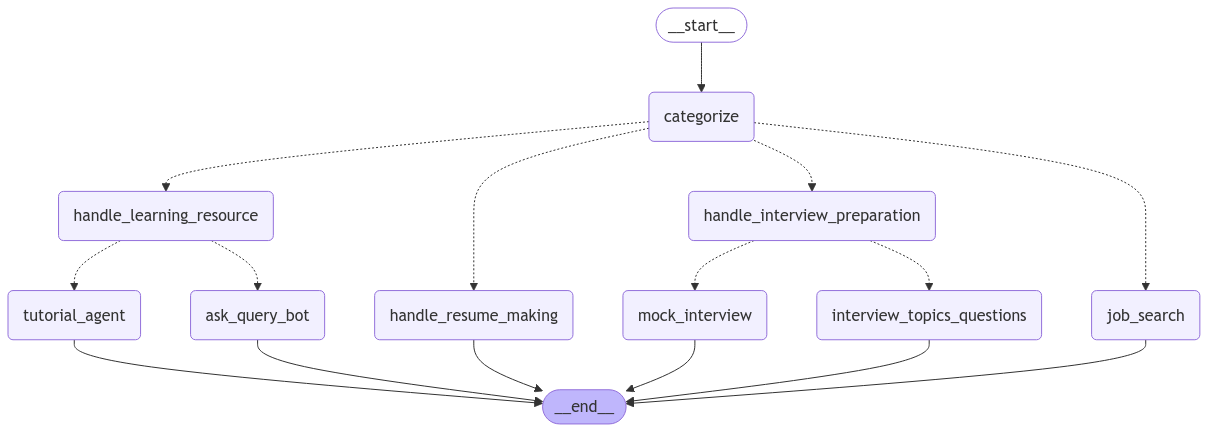

In [16]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [17]:
def run_user_query(query:str)-> Dict[str,str]:
    """process a user query through the langgraph workflow."""

    results = app.invoke({"query":query})
    return {
        "category":results["category"],
        "response":results["response"]
    }

In [18]:
# query = "Can u conduct a Mock interview for me"
# result = run_user_query(query)
# result

In [20]:
query = " search for Generative AI, Data scientst jobs in Hyderabad, India for Freshers."
result = run_user_query(query)
result

Categorizing the customer query...
Category: job_search
File 'Agent_output\Job_search_20241217013443.md' created sucessfully.


# Data Science & AI Job Opportunities


## Summary of Available Positions

Several Data Scientist and related roles focusing on AI/ML, including Generative AI and Deep Learning, are available in Hyderabad, India, and potentially other locations in India.  Experience levels range from mid-level (5-7 years) to senior roles.  Strong technical skills in machine learning, deep learning, NLP, and related areas are essential.


## Detailed Job Listings

**1. Data Scientist**

* **Company:** Cognizant
* **Location:** Hyderabad, Telangana, India
* **Required Skills:** Machine Learning, Deep Learning, Problem-solving, Consultative approach
* **Experience Level:** Mid-level (5-7 years)
* **Job Description:** Apply ML and Deep Learning algorithms to solve business challenges. Identify the best combination of AI/ML techniques for problem-solving. Work closely with business teams to identify AI application opportunities. Document work for reproducibility, transparency, and ethical AI practices.
* **Application Link:** [https://careers.cognizant.com/india-en/jobs/00060501752/data-scientist/](https://careers.cognizant.com/india-en/jobs/00060501752/data-scientist/)


**2. Generative AI Data Scientist**

* **Company:** Expertia (for Santosystems)
* **Location:** Hyderabad
* **Required Skills:** Generative AI, Large Language Models (LLM), Machine Learning, transitioning research to production
* **Experience Level:** Senior
* **Job Description:** Develop and deploy Generative AI and LLM models.  Translate research and experiments into real-world AI/ML products.
* **Application Link:** [https://www.expertia.ai/santosystems/job/hiring-generative-ai-data-scientist-65dd9be2549a174c9ad61cd9](https://www.expertia.ai/santosystems/job/hiring-generative-ai-data-scientist-65dd9be2549a174c9ad61cd9)


**3. Data Scientist (Generative AI focus)**

* **Company:**  (Multiple companies - see Glassdoor listing)
* **Location:** India (160+ openings)
* **Required Skills:** Machine learning, Natural Language Processing (NLP), Generative AI, Graph Neural Networks, Topic Modeling, Experimental Design
* **Experience Level:**  Not specified (likely varies by specific role)
* **Job Description:**  Develop and apply various AI/ML techniques, with a focus on Generative AI. Design and conduct experiments.
* **Application Link:** [https://www.glassdoor.co.in/Job/india-gen-ai-data-scientist-jobs-SRCH_IL.0,5_KO6,27.htm](https://www.glassdoor.co.in/Job/india-gen-ai-data-scientist-jobs-SRCH_IL.0,5_KO6,27.htm)


**4. Data Scientist**

* **Company:** Novartis
* **Location:** Hyderabad (Office)
* **Required Skills:**  Not specified in snippet.
* **Experience Level:** Not specified in snippet.
* **Job Description:** Not detailed in snippet.
* **Application Link:** [https://aijobs.net/job/819083-data-scientist/](https://aijobs.net/job/819083-data-scientist/)


**5. Deep Learning Engineer & Data Scientist**

* **Company:** Not specified in snippet
* **Location:** Not specified in snippet
* **Required Skills:** Machine Learning, Deep Learning, Problem-solving, Consultative approach
* **Experience Level:** Not specified in snippet
* **Job Description:** Be a hands-on problem solver with a consultative approach. Apply ML and Deep Learning algorithms to address business challenges.
* **Application Link:** Not available in snippet

{'category': '4', 'response': 'Agent_output\\Job_search_20241217013443.md'}